In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Monthly_Timeseries.csv", index_col='Month', parse_dates=True)
df.index.freq = 'MS'

In [4]:
df.head()

,EG_(GWh)
Month,
2010-01-01,2624
2010-02-01,2336
2010-03-01,2432
2010-04-01,2126
2010-05-01,2095


<AxesSubplot:xlabel='Month'>

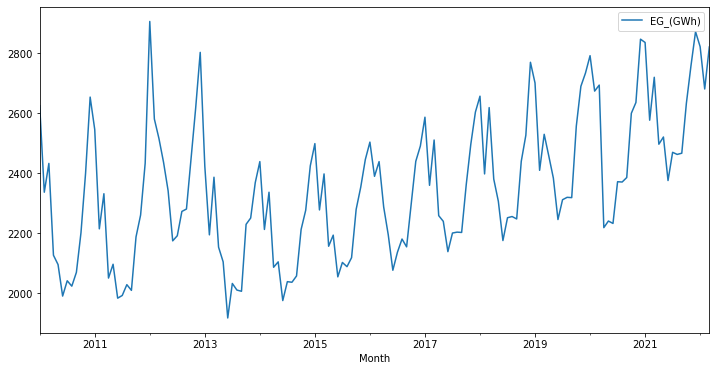

In [5]:
df.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

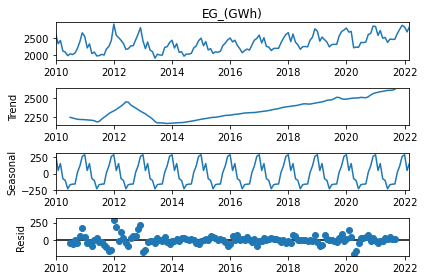

In [7]:
results = seasonal_decompose(df['EG_(GWh)'])
results.plot();

In [8]:
len(df)

147

In [17]:
train = df.iloc[:135]
test = df.iloc[135:]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
df.head(),df.tail()

(            EG_(GWh)
 Month               
 2010-01-01      2624
 2010-02-01      2336
 2010-03-01      2432
 2010-04-01      2126
 2010-05-01      2095,
             EG_(GWh)
 Month               
 2021-11-01      2757
 2021-12-01      2871
 2022-01-01      2821
 2022-02-01      2680
 2022-03-01      2820)

In [20]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
scaled_train[:10]

array([[0.71558704],
       [0.42408907],
       [0.52125506],
       [0.21153846],
       [0.18016194],
       [0.07388664],
       [0.12550607],
       [0.10728745],
       [0.15384615],
       [0.28744939]])

In [22]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [24]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.71558704 0.42408907 0.52125506]
Predict this y: 
 [[0.21153846]]


In [25]:
X.shape

(1, 3, 1)

In [26]:
# we will now do it for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [29]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
123/123 [==============================] - 4s 7ms/step - loss: 0.0514
Epoch 2/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0496
Epoch 3/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0469
Epoch 4/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0371
Epoch 5/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0257
Epoch 6/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0235
Epoch 7/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0231
Epoch 8/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0184
Epoch 9/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0174
Epoch 10/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0163
Epoch 11/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0182
Epoch 12/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0166
Epoch 13/50
123/123 [====

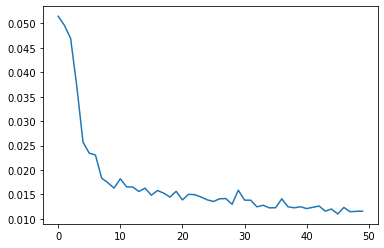

In [32]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [33]:
last_train_batch = scaled_train[-12:]

In [34]:
print(scaled_train.shape)

(135, 1)


In [35]:
print(n_input)
print(n_features)

12
1


In [36]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [37]:
print(last_train_batch)

[[[0.30465587]
  [0.32692308]
  [0.31882591]
  [0.45951417]
  [0.45850202]
  [0.47368421]
  [0.6902834 ]
  [0.72672065]
  [0.9402834 ]
  [0.9291498 ]
  [0.66700405]
  [0.81174089]]]


In [38]:
model.predict(last_train_batch)

array([[0.48768848]], dtype=float32)

In [39]:
scaled_test[0]

array([0.58603239])

In [40]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# print(len(current_batch))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [41]:
test_predictions

[array([0.48768848], dtype=float32),
 array([0.4086065], dtype=float32),
 array([0.41327262], dtype=float32),
 array([0.48063198], dtype=float32),
 array([0.5740369], dtype=float32),
 array([0.7231712], dtype=float32),
 array([0.8572353], dtype=float32),
 array([0.910349], dtype=float32),
 array([0.8897145], dtype=float32),
 array([0.77766824], dtype=float32),
 array([0.63001055], dtype=float32),
 array([0.48809177], dtype=float32)]

In [42]:
test.head()

,EG_(GWh)
Month,
2021-04-01,2496
2021-05-01,2520
2021-06-01,2375
2021-07-01,2469
2021-08-01,2462


In [43]:
true_predictions = scaler.inverse_transform(test_predictions)

In [44]:
test['Predictions'] = true_predictions

<ipython-input-44-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [45]:
test.head(10)

,EG_(GWh),Predictions
Month,,
2021-04-01,2496,2398.836220
2021-05-01,2520,2320.703221
2021-06-01,2375,2325.313348
2021-07-01,2469,2391.864394
2021-08-01,2462,2484.148453
2021-09-01,2466,2631.493120
2021-10-01,2632,2763.948489
2021-11-01,2757,2816.424823
2021-12-01,2871,2796.037906


<AxesSubplot:xlabel='Month'>

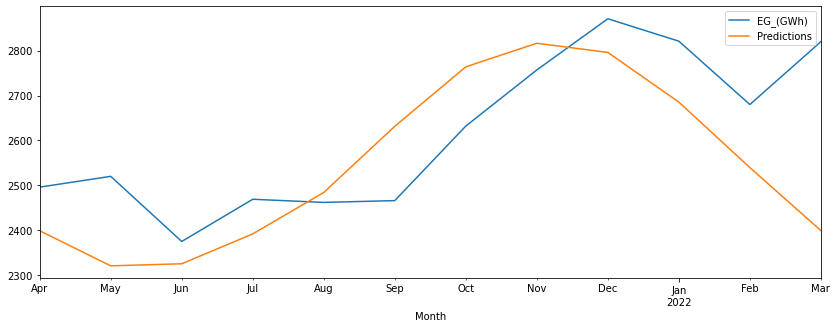

In [46]:
test.plot(figsize=(14,5))

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['EG_(GWh)'],test['Predictions']))
print(rmse)

165.13139716879303


In [48]:
from keras.layers import Dropout

In [49]:
# model---2

In [50]:
# define model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(n_input, n_features)))

model.add(Dense(150, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(200, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(400, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 150)               15150     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               30200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 400)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                

In [52]:
model.fit(generator, epochs=50)

Epoch 1/50
123/123 [==============================] - 6s 8ms/step - loss: 0.0544
Epoch 2/50
123/123 [==============================] - 1s 9ms/step - loss: 0.0331
Epoch 3/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0236
Epoch 4/50
123/123 [==============================] - 1s 9ms/step - loss: 0.0221
Epoch 5/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0186
Epoch 6/50
123/123 [==============================] - 1s 9ms/step - loss: 0.0243
Epoch 7/50
123/123 [==============================] - 1s 9ms/step - loss: 0.0191
Epoch 8/50
123/123 [==============================] - 1s 9ms/step - loss: 0.0223
Epoch 9/50
123/123 [==============================] - 1s 10ms/step - loss: 0.0163
Epoch 10/50
123/123 [==============================] - 1s 9ms/step - loss: 0.0201
Epoch 11/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0228
Epoch 12/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0220
Epoch 13/50
123/123 [===

In [53]:
model.save("Base_Model_2/")

INFO:tensorflow:Assets written to: Base_Model_2/assets


INFO:tensorflow:Assets written to: Base_Model_2/assets


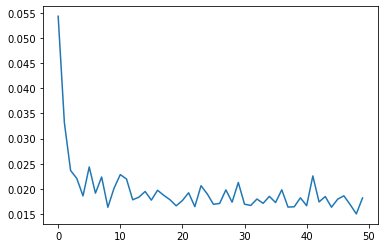

In [54]:
loss_each_epochs = model.history.history['loss']
plt.plot(range(len(loss_each_epochs)), loss_each_epochs)

In [55]:
last_train_batch = scaled_train[-12:]

In [56]:
print(scaled_train.shape)

(135, 1)


In [57]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [58]:
model.predict(last_train_batch)

array([[0.6903765]], dtype=float32)

In [59]:
scaled_test[0]

array([0.58603239])

In [60]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# print(len(current_batch))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [61]:
true_predictions = scaler.inverse_transform(test_predictions)

In [62]:
test['Predictions'] = true_predictions

<ipython-input-62-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [63]:
test

,EG_(GWh),Predictions
Month,,
2021-04-01,2496,2599.092002
2021-05-01,2520,2581.324720
2021-06-01,2375,2585.807439
2021-07-01,2469,2612.175634
2021-08-01,2462,2652.184908
2021-09-01,2466,2689.087002
2021-10-01,2632,2710.222168
2021-11-01,2757,2715.893216
2021-12-01,2871,2708.929310


<AxesSubplot:xlabel='Month'>

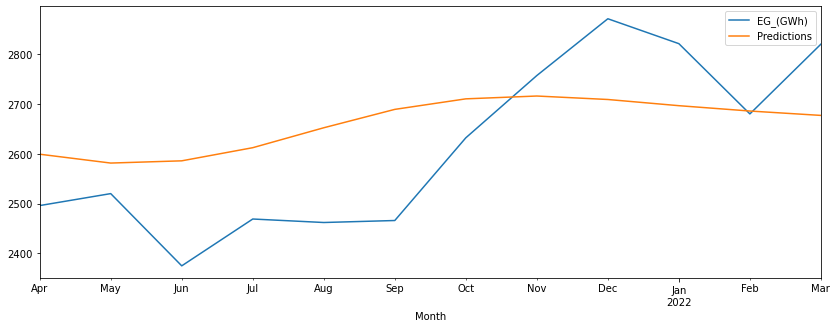

In [64]:
test.plot(figsize=(14,5))

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['EG_(GWh)'],test['Predictions']))
print(rmse)

140.03764539507168


In [70]:
print("Root Mean Squared Error",rmse)

Root Mean Squared Error 140.03764539507168


In [71]:
from sklearn.metrics import mean_absolute_error
mse = mean_absolute_error(test['EG_(GWh)'],test['Predictions'])
print(mse)

123.86248934268967


In [73]:
print("Root Mean Squared Error",rmse)
print("Mean Absolute Error",mse)

Root Mean Squared Error 140.03764539507168
Mean Absolute Error 123.86248934268967


In [68]:
# from sklearn.metrics import me

In [69]:
import numpy as np
# y_hat = np.array([0.000, 0.166, 0.333])
# y_true = np.array([0.000, 0.254, 0.998])

# print("d is: " + str(["%.8f" % elem for elem in y_hat]))
# print("p is: " + str(["%.8f" % elem for elem in y_true]))

def mae(predictions, targets):
    differences = predictions - targets
    absolute_differences = np.absolute(differences)
    mean_absolute_differences = absolute_differences.mean()
    return mean_absolute_differences


mae_val = mae(test['EG_(GWh)'], test['Predictions'])
print ("mae error is: " + str(mae_val))

mae error is: 123.86248934268967
